In [1]:
%matplotlib inline 
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from IPython import display
import random 
import matplotlib

# LOAD TRAINING DATA
train_mat = scipy.io.loadmat('data/mnist_data/images.mat')
train_images_raw = train_mat['images'].T
train_images_corrected = []
for i in range(len(train_images_raw)):
    train_images_corrected.append(train_images_raw[i].T.ravel())
train_images_corrected = np.array(train_images_corrected)
#Now let's try kmeans clusterings


In [2]:

# 1 reclassify
# 2 reset mean.

#A single iteration of reclassification.


def kmeans(data, k):
    mu = [np.random.rand(data[0].shape[0])*255/2.0 for i in range(k)]
    k_classes = [[] for i in range(k)]
    changed = True
    truth = [True for i in range(k)]
    while changed:


        for image in data:
            index, closest, dif  = 0, mu[0], 100000000000
            for i, mu_i in enumerate(mu):
                dist = np.linalg.norm(mu_i - image)
                if dist < dif:
                    index,closest,dif = i, mu_i, dist

            k_classes[index].append(image)


        for i in range(len(mu)):
            temp = np.mean(k_classes[i], axis=0)
            truth[i] = temp != mu[i]
            mu[i] = temp

        for val in truth:
            if val is True:
                changed = True
                break
            else:
                changed = False

    return mu, k_classes

Class 0 Count: 15103


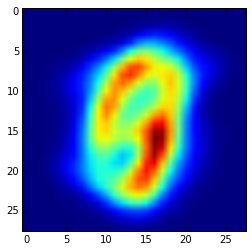

Class 1 Count: 4753


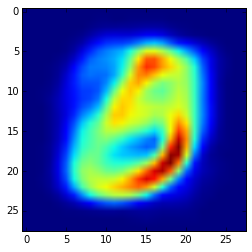

Class 2 Count: 8557


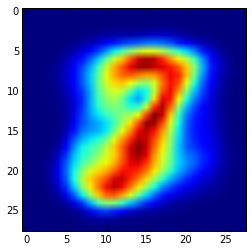

Class 3 Count: 270


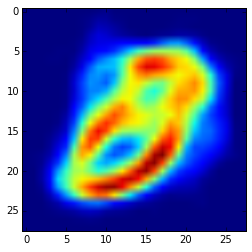

Class 4 Count: 7002


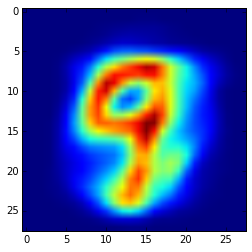

Class 5 Count: 121


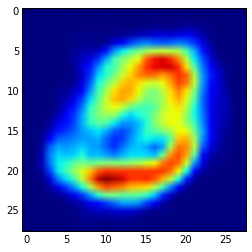

Class 6 Count: 6134


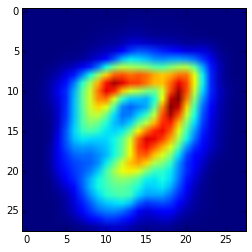

Class 7 Count: 482


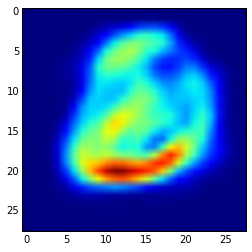

Class 8 Count: 10836


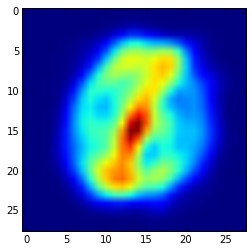

Class 9 Count: 6742


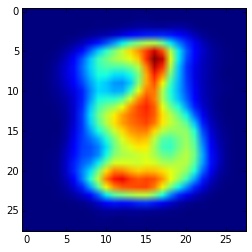

In [5]:
k = 10
mu, classes = kmeans(train_images_corrected, k)
for i in range(k):
    plt.imshow(mu[i].reshape(28,28))
    print("Class", i, "Count:", len(classes[i]))
    fuck = "class" + str(i);
    plt.savefig(fuck + ".png")
    plt.show()

# Joke Recommender System
First we'll need to load the data.

In [3]:
joke_train_mat = scipy.io.loadmat('./data/joke_data/joke_train.mat')
j_up_train = joke_train_mat['train']

#load validation set.
from numpy import genfromtxt
valid_data = genfromtxt('./data/joke_data/validation.txt', delimiter=',')
valid_data[valid_data == 0] = -1
valid_data = valid_data - np.array([1,1,0])


def loss(user, joke, actual, predictor):
    pred = predictor(user,joke)
    return np.sign(pred) != np.sign(actual)*1

def validate(predictor):
    net_error = 0
    for example in valid_data:
        net_error += loss(example[0], example[1], example[2], predictor)
    return net_error/len(valid_data)

In [4]:
# simple system. Get the average rating of a joke.
#copy the up_train
j_avg_train = np.array(j_up_train[:,:])
j_avg_train_nan_index = np.isnan(j_avg_train)
j_avg_train[j_avg_train_nan_index] = 0
j_score = np.mean(j_avg_train, axis=0)
#j_score is the joke score.

def lame_score(user, joke):
    return j_score[joke]

validate(lame_score)

0.3796747967479675

# k-Nearest Neighboors.
We do a k-nearest neighboors approach and take the average of those nearest neighboors. Supervised power in the aggreegate that is the crowd.

In [13]:
# First lets calculate the distance matrix on all of these dudes. :)
import scipy.spatial
j_dist_matrix = scipy.spatial.distance.pdist(j_avg_train, 'euclidean')

In [14]:
cache = {}
condensed_idx = lambda i,j,n: i*n + j - i*(i+1)/2 - i - 1
def getid(ii,jj):
    i = min(ii,jj)
    j = max(ii,jj)
    return condensed_idx(i,j,len(j_avg_train))

def get_k_classifier(k):
    print(k)
    def knn_score(user, joke):
        # get k closest neighboors
        if user not in cache:
            cache[user] = np.argsort([j_dist_matrix[getid(user,j)]*(j != user) for j in range(len(j_avg_train))])
        
        neighbors = cache[user][:k]
        return np.mean(np.array(list(map(lambda i: j_avg_train[i][joke], neighbors))))

    return knn_score
    

10
100
1000


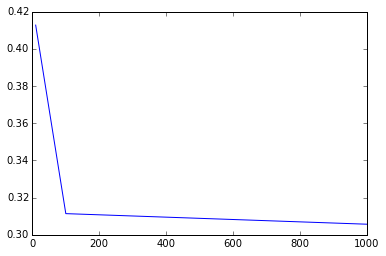

In [15]:
ks = [10, 100, 1000]
error = []
for k in ks:
    error.append(validate(get_k_classifier(k)))
plt.plot(ks, error)

# Latent Factor Model
We use the latent factor model on our data

In [5]:
# First let's try SVD on the 0 replaced matrix
U, s, V = np.linalg.svd(j_avg_train, full_matrices=False)

In [6]:

def j_avg_mse(U, S, V):
    pred = U.dot(S.dot(V))
    net = 0
    n= 0
    for i in range(j_up_train.shape[0]):
        for j in range(j_up_train.shape[1]):
            if not np.isnan(j_up_train[i,j]):
                net += (pred[i,j] - j_up_train[i,j])**2
                n += 1
                
    return net/n
    
    

2
3
4
5
6
7
8
9
10
20
100


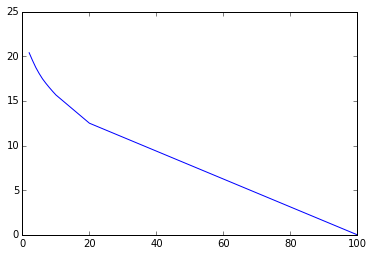

In [8]:
ds = [2,3,4,5,6,7,8,9,10,20,100]
error = []
for d in ds:
    print(d)
    S = np.diag(np.append(s[:d], np.zeros(len(s)-d)))
    error.append(j_avg_mse(U,S,V))
plt.plot(ds,error)

In [7]:
# Let's see our validation error.
def get_latent(d):
    S = np.diag(np.append(s[:d], np.zeros(len(s)-d)))
    Vprime = S.dot(V)
    def latent_classifier(user ,joke):
        return U[user].dot(Vprime.T[joke])
    return latent_classifier

[0.34037940379403792,
 0.29485094850948512,
 0.29051490514905148,
 0.28319783197831977,
 0.28455284552845528,
 0.28644986449864501,
 0.28563685636856367,
 0.28184281842818426,
 0.27859078590785907,
 0.28346883468834688,
 0.31409214092140919,
 0.52032520325203258]

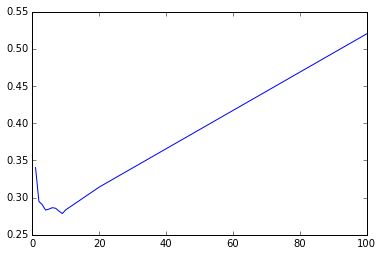

In [10]:
ds = [1,2,3,4,5,6,7,8,9,10,20,100]
error = []
for d in ds:
    error.append(validate(get_latent(d)))
plt.plot(ds,error)
error

# Latent Minimizers
We now use the alternating minimizer strategy

In [8]:
S = np.isfinite(j_up_train)

class latent_factor_model:
    def __init__(self, lab):
        self.lab = lab
        self.u = np.random.random(U.shape)
        self.v = np.random.random(V.shape)
    
    def minimize_u(self):
        v_outer = []
        for l in range(len(self.v)):
            v_outer.append(np.outer(self.v[l], self.v[l]))
        
        for i in range(len(self.u)):
            inv = sum([v_outer[l] for l in range(len(self.v)) if S[i,l]])
            inv += self.lab*np.identity(len(inv))
            other = sum([self.v[l]*j_up_train[i,l] for l in range(len(self.v)) if S[i,l]])
            self.u[i] =  np.linalg.inv(inv).dot(other)
        pass
    
    def minimize_v(self):
        u_outer = []
        for k in range(len(self.u)):
            u_outer.append(np.outer(self.u[k], self.u[k]))
        
        for j in range(len(self.v)):
            inv = sum([u_outer[k] for k in range(len(self.u)) if S[k,j]])
            inv += self.lab*np.identity(len(inv))
            other = sum([self.u[k]*j_up_train[k,j] for k in range(len(self.u)) if S[k,j]])
            self.v[j] =  np.linalg.inv(inv).dot(other)
        pass
    
    
    def trainer(self):
        while True:
            self.minimize_u()
            print("Minimized u")
            self.minimize_v()
            print("Minimized v")


            yield self.lfm
        
    def lfm(self, user, joke):
        return self.u[user].dot(self.v[joke])
    

In [20]:
model = latent_factor_model(10)
trainer = model.trainer()
for i in range(10):
    print("Epoch", i)
    errors.append(validate(next(trainer)))
    print(errors[i])

Epoch 0
Minimized u
Minimized v
0.361517615176
Epoch 1
Minimized u
Minimized v
0.359078590786
Epoch 2
Minimized u
Minimized v
0.369376693767
Epoch 3
Minimized u
Minimized v
0.360704607046
Epoch 4
Minimized u
Minimized v
0.356639566396
Epoch 5
Minimized u
Minimized v
0.349593495935
Epoch 6
Minimized u
Minimized v
0.341192411924
Epoch 7
Minimized u
Minimized v
0.333333333333
Epoch 8
Minimized u
Minimized v
0.331978319783
Epoch 9
Minimized u
Minimized v
0.328184281843


In [21]:
for i in range(10):
    print("Epoch", i)
    errors.append(validate(next(trainer)))
    print(errors[-1])

Epoch 0
Minimized u
Minimized v
0.320054200542
Epoch 1
Minimized u
Minimized v
0.315989159892
Epoch 2
Minimized u
Minimized v
0.310840108401
Epoch 3
Minimized u
Minimized v
0.307859078591
Epoch 4
Minimized u
Minimized v
0.30216802168
Epoch 5
Minimized u
Minimized v
0.29972899729
Epoch 6
Minimized u
Minimized v
0.29783197832
Epoch 7
Minimized u
Minimized v
0.29539295393
Epoch 8
Minimized u
Minimized v
0.292411924119
Epoch 9
Minimized u
Minimized v
0.285094850949


In [26]:
for i in range(10):
    print("Epoch", i)
    errors.append(validate(next(trainer)))
    print(errors[-1])

Epoch 0
Minimized u
Minimized v
0.283197831978
Epoch 1
Minimized u
Minimized v
0.281571815718
Epoch 2
Minimized u
Minimized v
0.279674796748
Epoch 3
Minimized u
Minimized v
0.277506775068
Epoch 4
Minimized u
Minimized v
0.276693766938
Epoch 5
Minimized u
Minimized v
0.275880758808
Epoch 6
Minimized u
Minimized v
0.277506775068
Epoch 7
Minimized u


KeyboardInterrupt: 

In [27]:
model.minimize_v()

In [29]:
#Okay so now let's do our validation
1 - validate(model.lfm) #accuracy

0.72276422764227644

In [30]:

#load test set.
from numpy import genfromtxt
valid_data = genfromtxt('./data/joke_data/query.txt', delimiter=',')
valid_data = valid_data - np.array([0,1,1])

def run_test(predictor):
    predictions = []
    for row in valid_data:
        score = predictor(row[1], row[2]) 
        
        predictions.append((score > 0)*1)
    return np.array(predictions)

In [32]:
preds = run_test(model.lfm)

In [35]:
np.savetxt('kaggle.csv', preds.astype(int), delimiter=',') 

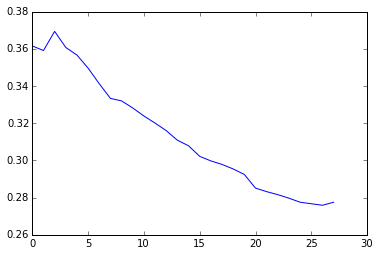

In [34]:
plt.plot(errors)

In [36]:
np.savetxt('lfm_u.txt', model.u) 

In [37]:
np.savetxt('lfm_v.txt', model.v)